In [1]:
--constructs a CDBN with a specific structure as specified

In [24]:
require 'nn'
require 'image'


In [25]:
require("posteriorProbabilityActivationsFile")

true	


In [5]:
--[[
local postProbActivations, parent = torch.class('posteriorProbabilityActivations','nn.Module')

function postProbActivations:updateOutput(input)
    input[torch.le(input,0.5)] = 0
    input[torch.ge(input,0.5)] = 1
    self.output = input
    return self.output
end


function postProbActivations:updateGradInput(input, gradOutput)
    return self.gradInput
end]]--

In [4]:
--helloWorld()
test = posteriorProbabilityActivations


[string "local f = function() return bla(model) end; l..."]:1: attempt to call global 'bla' (a nil value)
stack traceback:
	[string "local f = function() return bla(model) end; l..."]:1: in function 'f'
	[string "local f = function() return bla(model) end; l..."]:1: in main chunk
	[C]: in function 'xpcall'
	/usr/local/share/lua/5.1/itorch/main.lua:177: in function </usr/local/share/lua/5.1/itorch/main.lua:143>
	/usr/local/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/usr/local/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/usr/local/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/usr/local/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/usr/local/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/home/yingtone/.ipython/profile_default..."]:1: in main chunk: 

In [16]:
--testTensor = torch.Tensor(4,5,3,2):fill(0.51)

In [1]:
--test:forward(testTensor)

In [1]:
testReadFile = torch.DiskFile('lfwDataSetShort.foo', 'r')
testRead = testReadFile:readObject()

In [2]:
testRead:size()


 142
 250
 250
[torch.LongStorage of size 3]



In [38]:
restrictSet = testRead[{{1},{},{}}]:clone() --selecting the first three images

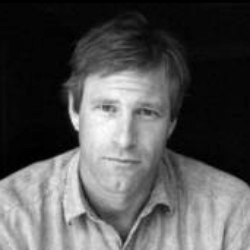

In [39]:
itorch.image(restrictSet)

In [40]:
blablabla = model:forward(restrictSet)

In [41]:
blablabla:size()


 96
 25
 25
[torch.LongStorage of size 3]



In [26]:
--Start with some arbitrary parameters - will function-ise later.
-- 2 hidden layers - K_1 = 32, K_2 = 96, i.e. L=2
-- C_1 = 3 = C_2 for pooling
-- N_w1 = N_w2 = 20 to start

--setup parameters - these will be input to the function 
L = 2 --i.e. L is the number of hidden layers.
filterCountArray = {32,96}
poolingRatioArray = {3,3} --Assuming square pools
convFilterSizeArray = {20,20} --Assuming square convolutional filters

--NB, if the filter sizes and the images don't quite line-up then we might lose the information at the edges; 
--  could use padding in this case but let's not worry about it now.
--  i.e. for a 7x7 image and 3x3 pools, we'd lose the rightmost and bottom-most edge of pixels.

model = nn.Sequential() --oops, set this to a function declaration first time around
model:add(nn.SpatialConvolution(1,filterCountArray[1],convFilterSizeArray[1],convFilterSizeArray[1]))
--Once the spatialConvolution layer has been applied, we now need to figure out the probability of posterior
--  unit activation, which is what this next chunk is for.
--  First, we apply exponentials to each term, then sum over the pools. This is done *slightly* hack-ily, since
--  we use the spatial average then multiply back up to get the sum. Depending on how the spatialAveragePooling
--  is carried out this may introduce some bias at the edges of the image (e.g. if the spatialAveragePooling
--  operation is smart enough to divide by a different number for the edges then we have said bias.)
--  Carrying on, we then use SoftSign() (for each term in the tensor X we calculate x_i/(1+|x_i|)), which is
--  our posterior unit activation probability.
--  
model:add(nn.Exp())
model:add(nn.SpatialAveragePooling(poolingRatioArray[1],poolingRatioArray[1],poolingRatioArray[1],poolingRatioArray[1]))
model:add(nn.Mul())
model:get(4).weight = torch.Tensor(1):fill(poolingRatioArray[1]*poolingRatioArray[1])
model:add(nn.SoftSign())
--At this point the values in the model should be the probability of posterior unit activations. I can't find
--  a function layer that switches values to 1 if values are greater than 0.5 and 0 if less than 0.5, so I'm
--  going to write a custom module that should accomplish this.

--Uh, so I have called the new class posteriorProbabilityActivatins that works... for some reason, even though
--  the require action complains alot.

model:add(posteriorProbabilityActivations())
--model:add(nn.Add(???))
--model:add(nn.SpatialMaxPooling(poolingRatioArray[1],poolingRatioArray[1]) )

--if more than 1 hidden layer to add we execute the next loop.
if L > 1 then
    for i = 2,L do
        model:add(nn.SpatialConvolution(filterCountArray[i-1],filterCountArray[i],convFilterSizeArray[i],convFilterSizeArray[i]))
        model:add(nn.Exp())
        model:add(nn.SpatialAveragePooling(poolingRatioArray[i],poolingRatioArray[i],poolingRatioArray[i],poolingRatioArray[i]))
        model:add(nn.Mul())
        --next line sets the weight of the nn.Mul() layer
        model:get(i*6-2).weight = torch.Tensor(1):fill(poolingRatioArray[i]*poolingRatioArray[i])
        model:add(nn.SoftSign())
        model:add(posteriorProbabilityActivations())
        --model:add(nn.SpatialMaxPooling(poolingRatioArray[i],poolingRatioArray[i] ))
    end
end

--Going to need to debug this to see correct behaviour, but the dimensions seem right.


In [20]:
littleForwardTest = torch.Tensor(1,250,250)
littleForwardTest[1] = testRead[1]:clone()

In [7]:
model:get(4)

nn.Mul
{
  gradInput : DoubleTensor - empty
  weight : DoubleTensor - size: 1
  gradWeight : DoubleTensor - size: 1
  output : DoubleTensor - empty
}


In [22]:
 -- "model" function call brings back details of the network, like what layers are at what index
    -- and an overview of the parameters of each of the layers. Useful for diagnostics.

    --From the documentation, "Sequential provides a means to plug layers together in a feed-forward
    --fully connected manner." This is exactly what we need, as although we have a convolutional action
    --action going, the posterior of the units are then "fully connected" to the next layer to use as the
    --visible units of the next CRBM
--model:get(10).weights

testForward = model:forward(littleForwardTest)
--testForwardFull = model:forward(testRead)

In [32]:
--print(testForward:size())
--print(testForward[3])
repLayer = nn.Mul()
repLayer.weights = torch.Tensor(1):fill(255)
--itorch.image(testForward)

In [ ]:
repLayer

In [33]:
representation = repLayer:forward(testForward)

In [35]:
--itorch.image(representation)
print(representation[1])

--model

Columns 1 to 10
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052 

052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
 0.8052  0.8052  0.8052  0.8052  0.8052
[torch.DoubleTensor of size 25x25]



nn.Add
{
  gradBias : DoubleTensor - size: 1
  bias : DoubleTensor - size: 1
  gradInput : DoubleTensor - empty
  _ones : DoubleTensor - size: 1
  scalar : 1
  output : DoubleTensor - empty
}


In [ ]:
-- Test CDBN values

In [135]:
--We're going to put in a 2 by 9x9 tensor to test with.

--modelTest = nn.Sequential() --oops, set this to a function declaration first time around
--modelTest:add(nn.SpatialConvolution(2,2,3,3))
--modelTest:add(nn.Exp())
--modelTest:add(nn.SpatialAveragePooling(3,3,3,3))
--modelTest:add(nn.Mul()) -- On initialisation sets random weight and expects to learn - we just want a constant
--modelTest:get(4).weight = torch.Tensor(1):fill(9)
--modelTest:add(nn.SoftSign()) --seems potentially right but need to check more specifically
modelTest:add(posteriorProbabilityActivations())
--modelTest

In [61]:
inputTensorTest = torch.Tensor(2,9,9)

In [67]:
s = inputTensorTest:storage()

In [159]:
for i = 1,s:size() do
    s[i] = i/1000000000000000000
end


In [160]:
inputTensorTest

(1,.,.) = 
 1e-16 *
   0.0100  0.0200  0.0300  0.0400  0.0500  0.0600  0.0700  0.0800  0.0900
   0.1000  0.1100  0.1200  0.1300  0.1400  0.1500  0.1600  0.1700  0.1800
   0.1900  0.2000  0.2100  0.2200  0.2300  0.2400  0.2500  0.2600  0.2700
   0.2800  0.2900  0.3000  0.3100  0.3200  0.3300  0.3400  0.3500  0.3600
   0.3700  0.3800  0.3900  0.4000  0.4100  0.4200  0.4300  0.4400  0.4500
   0.4600  0.4700  0.4800  0.4900  0.5000  0.5100  0.5200  0.5300  0.5400
   0.5500  0.5600  0.5700  0.5800  0.5900  0.6000  0.6100  0.6200  0.6300
   0.6400  0.6500  0.6600  0.6700  0.6800  0.6900  0.7000  0.7100  0.7200
   0.7300  0.7400  0.7500  0.7600  0.7700  0.7800  0.7900  0.8000  0.8100

(2,.,.) = 
 1e-16 *
   0.8200  0.8300  0.8400  0.8500  0.8600  0.8700  0.8800  0.8900  0.9000
   0.9100  0.9200  0.9300  0.9400  0.9500  0.9600  0.9700  0.9800  0.9900
   1.0000  1.0100  1.0200  1.0300  1.0400  1.0500  1.0600  1.0700  1.0800
   1.0900  1.1000  1.1100  1.1200  1.1300  1.1400  1.1500  1.1600  1.17

In [132]:
modelTest

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
  (1): nn.SpatialConvolution(2 -> 2, 3x3)
  (2): nn.Exp
  (3): nn.SpatialAveragePooling(3,3,3,3)
  (4): nn.Mul
  (5): nn.SoftSign
}
{
  gradInput : DoubleTensor - empty
  modules : 
    {
      1 : 
        nn.SpatialConvolution(2 -> 2, 3x3)
        {
          dH : 1
          dW : 1
          nOutputPlane : 2
          output : DoubleTensor - size: 2x7x7
          gradInput : DoubleTensor - empty
          finput : DoubleTensor - size: 18x49
          fgradInput : DoubleTensor - empty
          gradBias : DoubleTensor - size: 2
          weight : DoubleTensor - size: 2x2x3x3
          bias : DoubleTensor - size: 2
          gradWeight : DoubleTensor - size: 2x2x3x3
          padding : 0
          nInputPlane : 2
          kW : 3
          kH : 3
        }
      2 : 
        nn.Exp
        {
          gradInput : DoubleTensor - empty
          output : DoubleTensor - size: 2x7x7
        }
      3 : 
        nn.Spat

In [128]:
modelTest:get(4).weight

 9
[torch.DoubleTensor of size 1]



 modelTest:get(1).bias

In [161]:
testOutput2 = modelTest:forward(inputTensorTest)

In [81]:
testOutput

(1,.,.) = 
 Columns 1 to 6
  1.4278e+15  1.8872e+15  2.4943e+15  3.2967e+15  4.3573e+15  5.7591e+15
  1.7575e+16  2.3229e+16  3.0702e+16  4.0579e+16  5.3634e+16  7.0888e+16
  2.1633e+17  2.8593e+17  3.7791e+17  4.9949e+17  6.6018e+17  8.7256e+17
  2.6628e+18  3.5194e+18  4.6517e+18  6.1482e+18  8.1261e+18  1.0740e+19
  3.2776e+19  4.3321e+19  5.7257e+19  7.5677e+19  1.0002e+20  1.3220e+20
  4.0344e+20  5.3323e+20  7.0478e+20  9.3151e+20  1.2312e+21  1.6273e+21
  4.9659e+21  6.5635e+21  8.6751e+21  1.1466e+22  1.5155e+22  2.0030e+22

Columns 7 to 7
  7.6118e+15
  9.3694e+16
  1.1533e+18
  1.4196e+19
  1.7473e+20
  2.1508e+21
  2.6474e+22

(2,.,.) = 
 Columns 1 to 6
  8.5045e+06  9.2925e+06  1.0154e+07  1.1094e+07  1.2122e+07  1.3246e+07
  1.8880e+07  2.0630e+07  2.2541e+07  2.4630e+07  2.6912e+07  2.9405e+07
  4.1914e+07  4.5798e+07  5.0041e+07  5.4678e+07  5.9744e+07  6.5280e+07
  9.3050e+07  1.0167e+08  1.1109e+08  1.2139e+08  1.3263e+08  1.4492e+08
  2.0657e+08  2.2571e+08  2.4662e+0

In [85]:
testOutput

(1,.,.) = 
  1.0639e+17  2.4564e+17
  1.9840e+20  4.5810e+20

(2,.,.) = 
  2.5306e+07  3.3012e+07
  2.7688e+08  3.6119e+08
[torch.DoubleTensor of size 2x2x2]



In [130]:
testOutput

(1,.,.) = 
  9.5748e+17  2.2107e+18
  1.7856e+21  4.1229e+21

(2,.,.) = 
  2.2775e+08  2.9711e+08
  2.4919e+09  3.2507e+09
[torch.DoubleTensor of size 2x2x2]



In [134]:
testOutput

(1,.,.) = 
  1.0000  1.0000
  1.0000  1.0000

(2,.,.) = 
  1.0000  1.0000
  1.0000  1.0000
[torch.DoubleTensor of size 2x2x2]



In [137]:
testOutput

(1,.,.) = 
  1  1
  1  1

(2,.,.) = 
  1  1
  1  1
[torch.DoubleTensor of size 2x2x2]



In [162]:
modelTest:get(1).output

(1,.,.) = 
 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121
 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121
 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121
 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121
 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121
 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121
 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121 -0.2121

(2,.,.) = 
  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533
  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533
  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533
  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533
  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533
  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533
  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533  0.0533
[torch.DoubleTensor of size 2x7x7]



In [163]:
modelTest:get(2).output

(1,.,.) = 
  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089
  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089
  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089
  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089
  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089
  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089
  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089  0.8089

(2,.,.) = 
  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547
  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547
  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547
  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547
  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547
  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547
  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547  1.0547
[torch.DoubleTensor of size 2x7x7]



In [164]:
modelTest:get(3).output

(1,.,.) = 
  0.8089  0.8089
  0.8089  0.8089

(2,.,.) = 
  1.0547  1.0547
  1.0547  1.0547
[torch.DoubleTensor of size 2x2x2]



In [165]:
modelTest:get(4).output

(1,.,.) = 
  7.2803  7.2803
  7.2803  7.2803

(2,.,.) = 
  9.4923  9.4923
  9.4923  9.4923
[torch.DoubleTensor of size 2x2x2]



In [166]:
modelTest:get(5).output

(1,.,.) = 
  1  1
  1  1

(2,.,.) = 
  1  1
  1  1
[torch.DoubleTensor of size 2x2x2]



In [167]:
modelTest:get(6).output

(1,.,.) = 
  1  1
  1  1

(2,.,.) = 
  1  1
  1  1
[torch.DoubleTensor of size 2x2x2]

